In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import numpy as np
from Bio import pairwise2
from Bio.Seq import Seq
import os

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
os.chdir('/home/adri/Projects/phd/bias_2')

In [3]:
path = 'data/raw/alanin_scanning-cuantitative_values-emax_ec50.csv'
signaling_df = pd.read_csv(path)

In [4]:
# Read signling data
path = 'data/raw/alanin_scanning-cuantitative_values-emax_ec50.csv'
signaling_df = pd.read_csv(path)

# Remove mutations that are not alanin scan
alanin_scan_mask = signaling_df.Mutant.apply(lambda x: bool(re.match('([A-Z])(\d+)$', str(x))))
signaling_df = signaling_df.loc[alanin_scan_mask]

# Remove non usefull columns
cols_of_interst = ['Position','Emax_avg_corr_Gi2_HU210', 'EC50_avg_corr_Gi2_HU210',
                   'Emax_avg_corr_bArr1_HU210', 'EC50_avg_corr_bArr1_HU210', '%wt expression']
signaling_df = signaling_df[cols_of_interst]

# Change column names
signaling_df.columns = ['position', 'gi_emax', 'gi_ec50', 'barr_emax', 'barr_ec50', 'expression']

# Set boolean masks for biased and wt
gi_preferred_mask = (signaling_df.barr_emax == 0) & (signaling_df.gi_emax > 0)
wt_mask = (signaling_df.barr_emax > 0) & (signaling_df.gi_emax > 0)
barr_preferred_mask = (signaling_df.barr_emax > 0) & (signaling_df.gi_emax == 0)
both_mask = (signaling_df.barr_emax == 0) & (signaling_df.gi_emax == 0)

# Create a field wih categorical signal information
signaling_df['profile'] = 3
signaling_df.loc[wt_mask, 'profile'] = 0
signaling_df.loc[gi_preferred_mask, 'profile'] = 1
signaling_df.loc[barr_preferred_mask, 'profile'] = 2


# Remove mutants with other signaling profiles
# signaling_df = signaling_df[signaling_df.profile != 2]

In [5]:
signaling_df.profile.value_counts()

profile
0    250
1     64
3     41
2      4
Name: count, dtype: int64

In [6]:
signaling_df

,position,gi_emax,gi_ec50,barr_emax,barr_ec50,expression,profile
0,1,0.825515,0.098706,1.122299,0.385988,104.277644,0
1,2,0.615114,0.468060,0.907206,0.393758,116.723038,0
2,3,1.072523,-0.109611,0.826491,-0.361701,121.328063,0
3,4,1.203155,-0.047019,1.060027,-0.022091,84.004864,0
4,5,1.003370,-0.119622,1.008177,-0.119924,119.051109,0
...,...,...,...,...,...,...,...
367,356,1.062682,-0.189900,0.976102,0.130637,94.837573,0
368,357,1.167825,-0.240117,0.747814,0.007049,97.655672,0
369,358,1.107844,-0.101797,0.862811,0.468228,98.189135,0
370,359,1.158079,0.059214,0.744454,-0.265148,91.057497,0


In [7]:
# Add string labels
def cat_profile(x):
    if x == 0:
        return 'wt'
    elif x == 1:
        return 'barr_loss'
    elif x == 2:
        return 'Gi_loss'
    elif x == 3:
        return 'both_loss'
    
signaling_df['profile_lbl'] = signaling_df.profile.apply(cat_profile)

# Convert the residue id into a int column
signaling_df.position = signaling_df.position.astype(int)

In [8]:
signaling_df

,position,gi_emax,gi_ec50,barr_emax,barr_ec50,expression,profile,profile_lbl
0,1,0.825515,0.098706,1.122299,0.385988,104.277644,0,wt
1,2,0.615114,0.468060,0.907206,0.393758,116.723038,0,wt
2,3,1.072523,-0.109611,0.826491,-0.361701,121.328063,0,wt
3,4,1.203155,-0.047019,1.060027,-0.022091,84.004864,0,wt
4,5,1.003370,-0.119622,1.008177,-0.119924,119.051109,0,wt
...,...,...,...,...,...,...,...,...
367,356,1.062682,-0.189900,0.976102,0.130637,94.837573,0,wt
368,357,1.167825,-0.240117,0.747814,0.007049,97.655672,0,wt
369,358,1.107844,-0.101797,0.862811,0.468228,98.189135,0,wt
370,359,1.158079,0.059214,0.744454,-0.265148,91.057497,0,wt


In [9]:
signaling_df.profile_lbl.value_counts()

profile_lbl
wt           250
barr_loss     64
both_loss     41
Gi_loss        4
Name: count, dtype: int64

In [10]:
def get_conservation_df(basename):   
    
    # Load alignment dataframe
    alignment_df = pd.read_csv(f"data/raw/{basename}_gpcr_alignment.csv", index_col=0, header=1)
    
    # Extract the alignment of the cb2
    cb2_alignment = alignment_df.loc['[Human] CB2 receptor'].values
    
    # Extract the sequence without gaps
    alignment_cb2_seq = ''.join([res for res in cb2_alignment if res not in  ['_', '-']])
    
    # Get the sequence from uniprot
    uniprot_cb2_sequence = 'MEECWVTEIANGSKDGLDSNPMKDYMILSGPQKTAVAVLCTLLGLLSALENVAVLYLILSSH'\
    'QLRRKPSYLFIGSLAGADFLASVVFACSFVNFHVFHGVDSKAVFLLKIGSVTMTFTASVGSLLLTAIDRYLCLRYPPSYKALLTRGRAL'\
    'VTLGIMWVLSALVSYLPLMGWTCCPRPCSELFPLIPNDYLLSWLLFIAFLFSGIIYTYGHVLWKAHQHVASLSGHQDRQVPGMARMRLD'\
    'VRLAKTLGLVLAVLLICWFPVLALMAHSLATTLSDQVKKAFAFCSMLCLINSMVNPVIYALRSGEIRSSAHHCLAHWKKCVRGLGSEAK'\
    'EEAPRSSVTETEADGKITPWPDSRDLDLSDC'
    
    seq1 = Seq(alignment_cb2_seq) 
    seq2 = Seq(uniprot_cb2_sequence)
    alignments = pairwise2.align.globalms(seq1, seq2, 2, -1, -2, -1)
    al = alignments[0].seqA
    uni = alignments[0].seqB
    
#     print(al)
#     print(uni)
    
    equivalence = []
    for resid, (a, b) in enumerate(zip(al, uni), 1):
        if a != '-':
            equivalence.append(resid)
#     print(equivalence)
    # Loading conservation scores
    conservation_scores = []

    with open(f"data/raw/{basename}_conservation_scores.txt") as file:
        for line in file:
            if re.match('\d', line):
                conservation_scores.append(float(line.split('\t')[1]))
                
    res_mask = [True if not char in ['_', '-'] else False for char in cb2_alignment]
    conservation_scores = np.array(conservation_scores)[res_mask]
    order_resid_df = []
    for resid, score in zip(equivalence, conservation_scores):  
        order_resid_df.append([score, resid])

    order_resid_df = pd.DataFrame(order_resid_df, columns=[f'{basename}_score', 'resid'])
    order_resid_df = order_resid_df.dropna()
    
    return order_resid_df

In [11]:
class_a_conservation_df = get_conservation_df('class_a')
class_a_conservation_df

,class_a_score,resid
0,0.04546,29
1,0.04888,30
2,0.06530,31
3,0.05891,32
4,0.07116,33
...,...,...
251,0.12506,315
252,0.09567,316
253,0.07678,317
254,0.05014,318


In [12]:
# Load the contact frequency dataframe
path = 'data/processed/features_new.csv'
df = pd.read_csv(path, index_col=0)
simulated_mutants = df.mutant_id.unique()
simulated_mutants = [int(m) for m in simulated_mutants if m != 'wt']

/tmp/ipykernel_1838055/2252246761.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, index_col=0)


In [13]:
df = pd.merge(signaling_df, class_a_conservation_df, left_on='position', right_on='resid')
df = df.drop(['profile', 'resid'], axis=1)
df = df.fillna(0)

In [14]:
df

,position,gi_emax,gi_ec50,barr_emax,barr_ec50,expression,profile_lbl,class_a_score
0,29,1.377266,-0.080726,1.453091,0.204319,84.827855,wt,0.04546
1,30,1.057022,-0.067825,1.336484,0.075457,91.118165,wt,0.04888
2,31,1.131454,0.147191,1.090715,-0.039388,90.139799,wt,0.06530
3,32,1.430271,-0.130197,1.454057,0.259686,109.149191,wt,0.05891
4,33,1.045174,-0.112751,0.945484,0.555771,101.781051,wt,0.07116
...,...,...,...,...,...,...,...,...
250,315,1.284922,-0.033109,1.169000,0.396290,74.661364,wt,0.12506
251,316,1.215658,-0.287555,1.539277,0.171420,69.933913,wt,0.09567
252,317,1.364871,-0.056020,0.000000,8.942628,34.920211,barr_loss,0.07678
253,318,1.190868,-0.137452,0.790245,-0.354252,83.982672,wt,0.05014


In [15]:
simulated_df = df[df.position.isin(simulated_mutants)]
# simulated_df = df


In [16]:
df.profile_lbl.value_counts()

profile_lbl
wt           160
barr_loss     54
both_loss     38
Gi_loss        3
Name: count, dtype: int64

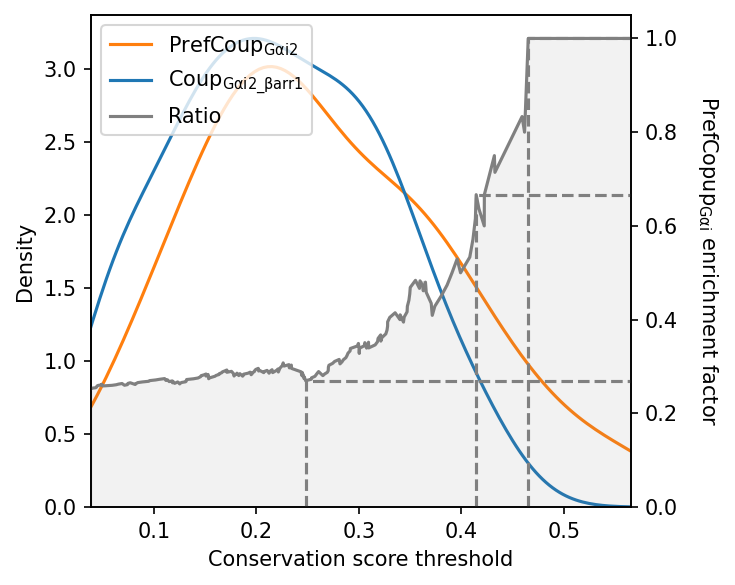

In [17]:
score = 'class_a_score'

fig, ax = plt.subplots(dpi=150, figsize=(5, 4))
# temp_df = df[df.expression.between(80, 120)]
temp_df = df[df.profile_lbl.isin(['wt', 'barr_loss'])]
sns.kdeplot(data=temp_df, x=score, hue='profile_lbl', common_norm=False)

lines = plt.gca().get_children()[:2]


sorted_df = temp_df.sort_values(score, ascending=False)

count_list = []
for i in range(1, sorted_df.shape[0]+1):
    counts = sorted_df.profile_lbl[:i].value_counts()
    count_list.append(counts)
    
counts_df = pd.concat(count_list, axis=1).transpose().fillna(0)

# Normalize counts
counts_df = counts_df.div(counts_df.sum(axis=1), axis=0).reset_index(drop=True).reset_index()

counts_df[score] = sorted_df[score].values
plt.xlabel('Conservation score threshold')
plt.twinx()
sns.lineplot(data=counts_df, x=score, y='barr_loss', color='grey')
plt.ylabel(r'$\mathrm{PrefCopup_{G\alpha i}}$ enrichment factor', 
           rotation=270, 
           labelpad=20)
plt.fill_between(counts_df[score].values, counts_df.barr_loss.values, color='grey', alpha=0.1)

plt.xlim((counts_df[score].min(), counts_df[score].max()))
plt.ylim(0,1.05)

# plt.axvline(0.25, color='grey')
# plt.axvline(0.415, color='grey')
# plt.axvline(0.465, color='grey')

# Mark key values on the enrichment score
x_values_to_mark = [0.25, 0.415, 0.465]
for val_to_mark in x_values_to_mark:

    # Find the closest value to the val to mark in the countsdf
    idx = abs(counts_df.class_a_score - val_to_mark).argmin()

    y, x = counts_df.iloc[idx].loc[['barr_loss', 'class_a_score']]

    # get the corresponding value of y
    # plot line from (x, 0) to (x, y) and from (x, y) to (y, max(x))
    plt.plot([x, x, counts_df[score].max()],[0, y, y], '--', color='grey')
    

ax.get_legend().remove()

plt.xlim((counts_df[score].min(), counts_df[score].max()))
plt.ylim(0,1.05)

lines += plt.gca().get_children()[:1]
plt.legend(lines, [r'$\mathrm{PrefCoup_{G\alpha i2}}$',
                    r'$\mathrm{Coup_{G\alpha i2\_\beta arr1}}$', 'Ratio'])

plt.tight_layout()

plt.savefig('results/evolutionary_conservation_analysis/bias_enrichment.png', facecolor='white')

plt.show()

In [21]:
def plot_distributions(df):
    score = 'class_a_score'

    df = df[df.profile_lbl.isin(['wt', 'barr_loss'])]
    
    sns.kdeplot(data=df, x=score, hue='profile_lbl',
                common_norm=False, hue_order=['wt', 'barr_loss'])

    plt.xlabel('Conservation score (JSD)')

    plt.tight_layout()

    # plt.savefig('results/evolutionary_conservation_analysis/bias_enrichment.png', facecolor='white')

/tmp/ipykernel_1838055/127131021.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


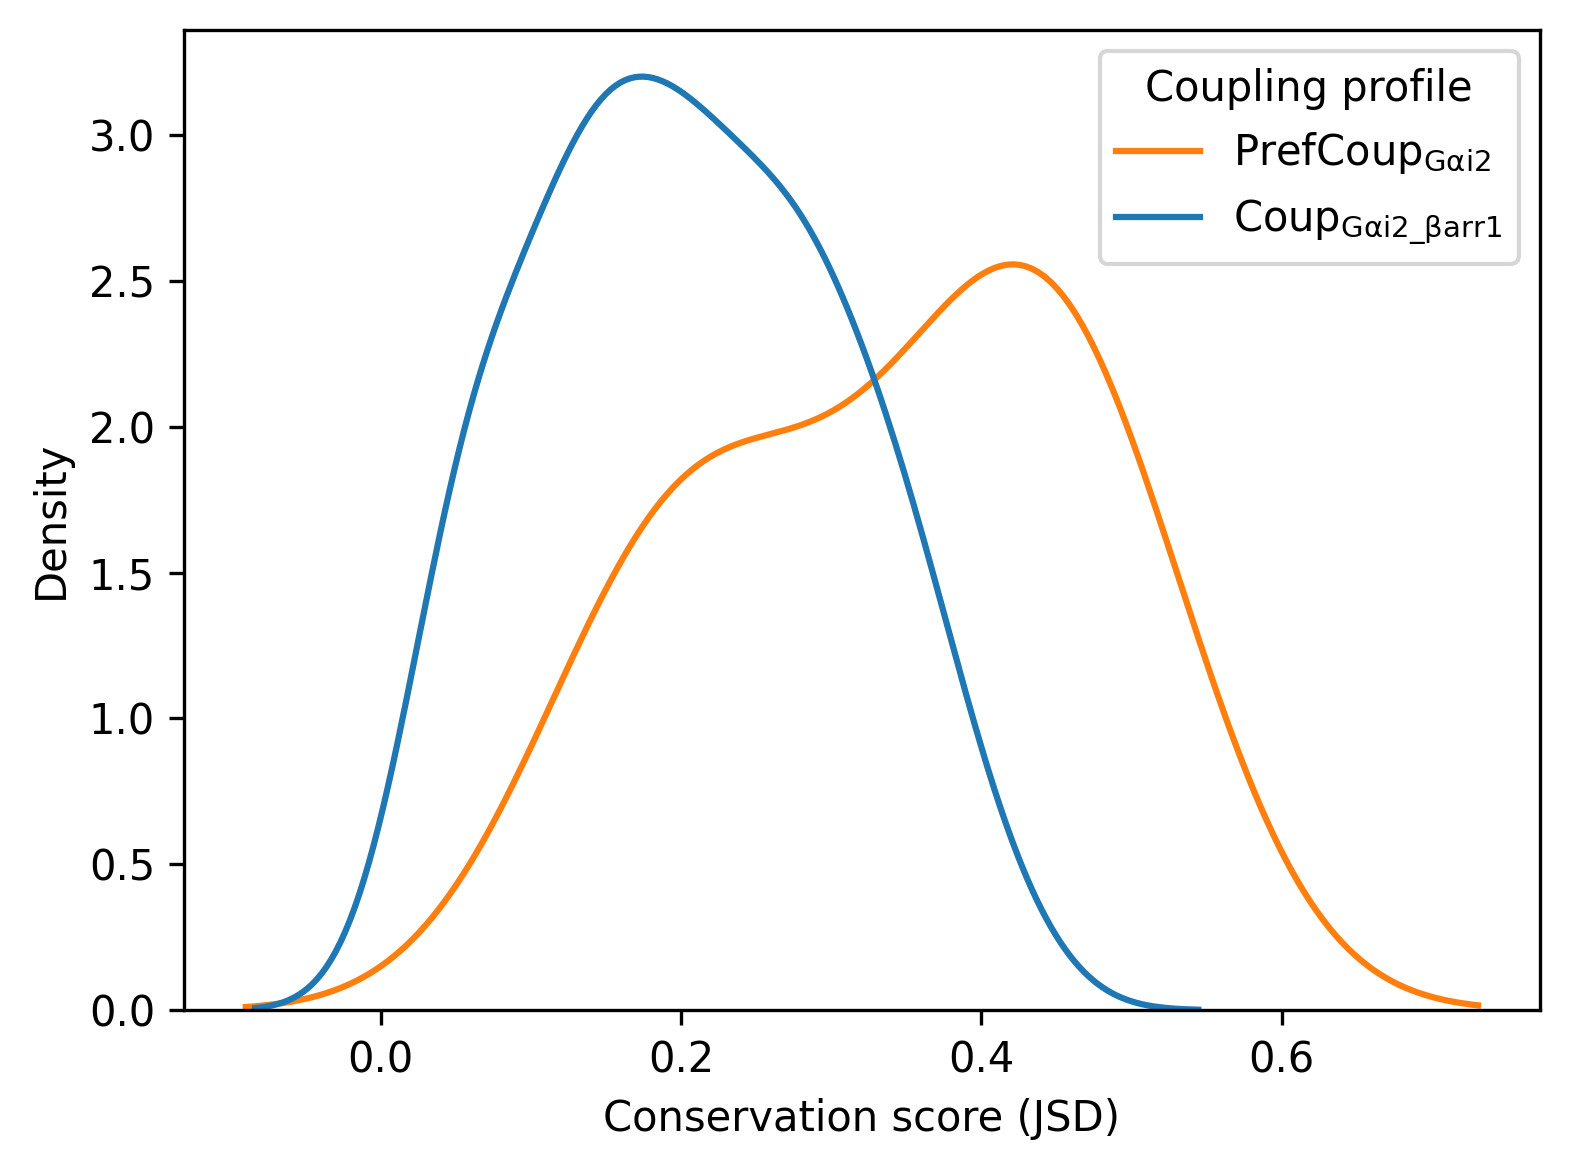

In [20]:
fig, ax = plt.subplots(dpi=300, figsize=(10, 4))
plt.subplot(1, 2, 1)
temp_df = df[df.expression.between(80, 120)]
plot_distributions(temp_df)
plt.legend(title='Coupling profile', labels=[r'$\mathrm{PrefCoup_{G\alpha i2}}$',
                                              r'$\mathrm{Coup_{G\alpha i2\_\beta arr1}}$'])

In [ ]:

fig, ax = plt.subplots(dpi=300, figsize=(10, 4))
plt.subplot(1, 2, 1)
temp_df = df[df.expression.between(80, 120)]
plot_distributions(temp_df)
plt.legend().remove()
plt.subplot(1, 2, 2)
temp_df = df.copy()
plot_distributions(temp_df)
plt.legend(title='Coupling profile', labels=[r'$\mathrm{PrefCoup_{G\alpha i2}}$',
                                              r'$\mathrm{Coup_{G\alpha i2\_\beta arr1}}$'])

plt.show()


In [43]:
df

,position,gi_emax,gi_ec50,barr_emax,barr_ec50,expression,profile_lbl,class_a_score
0,29,1.377266,-0.080726,1.453091,0.204319,84.827855,wt,0.04546
1,30,1.057022,-0.067825,1.336484,0.075457,91.118165,wt,0.04888
2,31,1.131454,0.147191,1.090715,-0.039388,90.139799,wt,0.06530
3,32,1.430271,-0.130197,1.454057,0.259686,109.149191,wt,0.05891
4,33,1.045174,-0.112751,0.945484,0.555771,101.781051,wt,0.07116
...,...,...,...,...,...,...,...,...
250,315,1.284922,-0.033109,1.169000,0.396290,74.661364,wt,0.12506
251,316,1.215658,-0.287555,1.539277,0.171420,69.933913,wt,0.09567
252,317,1.364871,-0.056020,0.000000,8.942628,34.920211,barr_loss,0.07678
253,318,1.190868,-0.137452,0.790245,-0.354252,83.982672,wt,0.05014


In [46]:
np.array(sns.color_palette())[[0,1,3,2]].tolist()

[[0.12156862745098039, 0.4666666666666667, 0.7058823529411765],
 [1.0, 0.4980392156862745, 0.054901960784313725],
 [0.8392156862745098, 0.15294117647058825, 0.1568627450980392],
 [0.17254901960784313, 0.6274509803921569, 0.17254901960784313]]

/tmp/ipykernel_2129403/99207340.py:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df, x='profile_lbl', y='class_a_score',


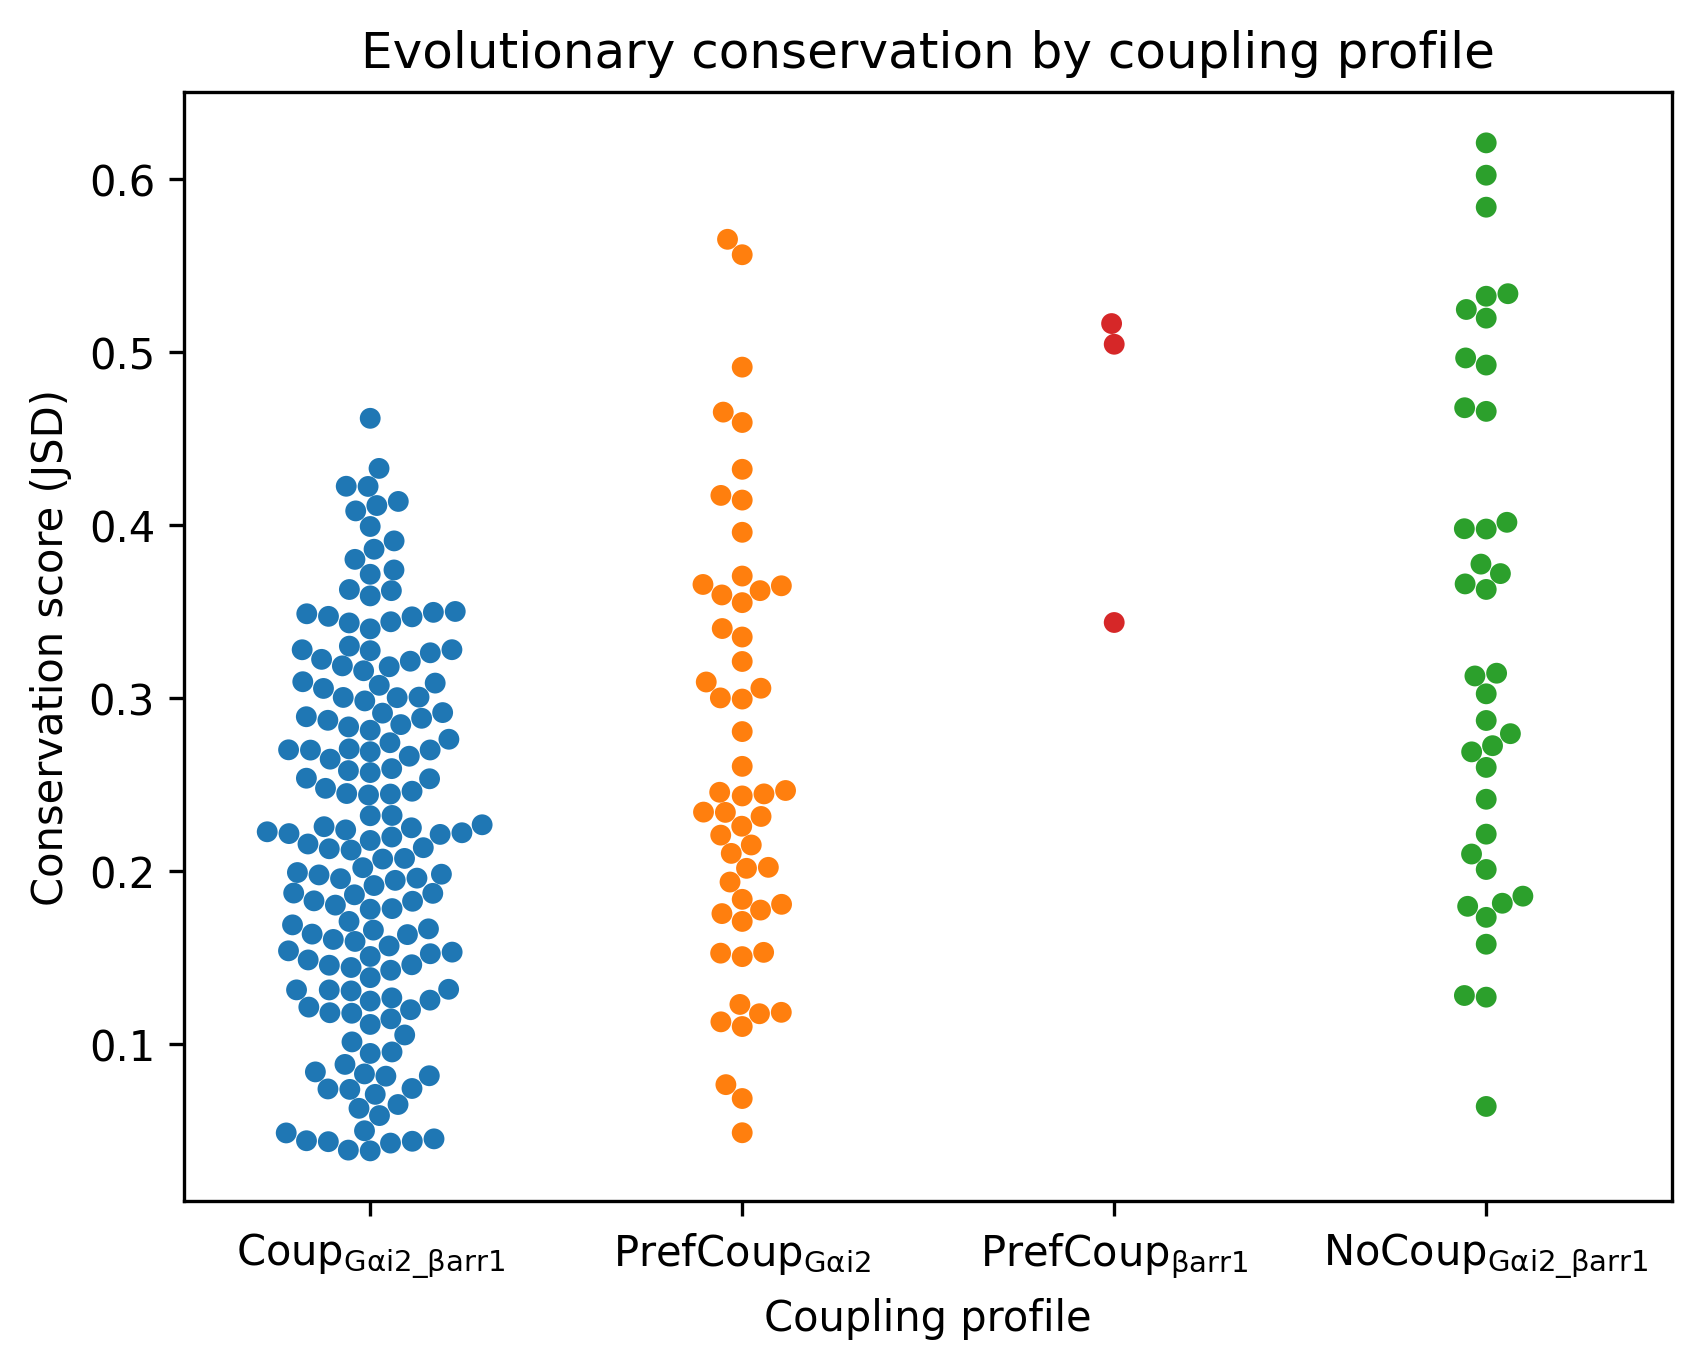

In [49]:
plt.figure(dpi=300)
sns.swarmplot(data=df, x='profile_lbl', y='class_a_score',
               order=['wt', 'barr_loss', 'Gi_loss', 'both_loss'],
                 palette=np.array(sns.color_palette())[[0,1,3,2]].tolist())

# change x ticks
new_tick_labels = [r'$\mathrm{Coup_{G\alpha i2\_\beta arr1}}$',
r'$\mathrm{PrefCoup_{G\alpha i2}}$',
r'$\mathrm{PrefCoup_{\beta arr1}}$',
r'$\mathrm{NoCoup_{G\alpha i2\_\beta arr1}}$']
plt.xticks(ticks=[0,1,2,3], labels=new_tick_labels)

plt.xlabel('Coupling profile')
plt.ylabel('Conservation score (JSD)')
plt.title('Evolutionary conservation by coupling profile')
plt.show()

In [ ]:
df.groupby('profile_lbl').class_a_score.mean()

profile_lbl
Gi_loss      0.454920
barr_loss    0.266725
both_loss    0.339107
wt           0.220607
Name: class_a_score, dtype: float64

# Check conservation scores of the ACN

In [21]:
 # get the ACN residues
acn_resids = [25, 58, 69, 70, 81, 84, 87, 90, 91, 94, 109, 115, 118, 121, 127, 128, 131, 135, 182,
              194, 237, 240, 247, 250, 253, 282, 285, 288, 291, 298, 301, 303]

In [22]:
class_a_conservation_df['acn'] = class_a_conservation_df.resid.isin(acn_resids).apply(lambda x: 'acn' if x else 'not_acn')

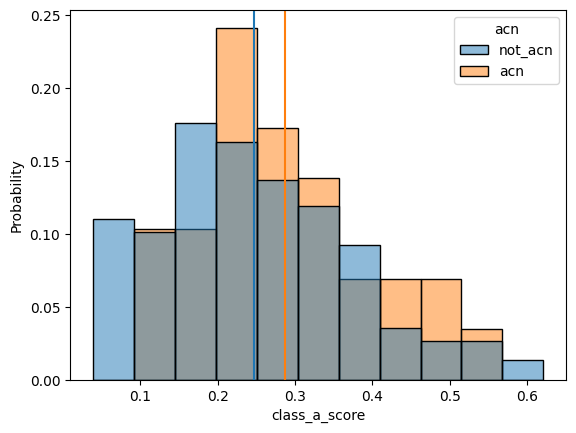

In [25]:
sns.histplot(data=class_a_conservation_df, x='class_a_score', hue='acn', stat='probability', common_norm=False)
# plot the means of acn and not_acn residues
plt.axvline(class_a_conservation_df[class_a_conservation_df['acn'] == 'acn']['class_a_score'].mean(),
             color=sns.color_palette()[1])
plt.axvline(class_a_conservation_df[class_a_conservation_df['acn'] == 'not_acn']['class_a_score'].mean(),
             color=sns.color_palette()[0])

In [32]:
from scipy.stats import ttest_ind

In [37]:
# Check if there is a significant difference in the evolutionary conservation of the two groups of sequences
# using the Wilcoxon rank-sum test.
acn_conservation = class_a_conservation_df[class_a_conservation_df.acn == 'acn'].class_a_score
non_acn_conservation = class_a_conservation_df[class_a_conservation_df.acn == 'not_acn'].class_a_score
stat, pval = ttest_ind(acn_conservation, non_acn_conservation)
print('Wilcoxon rank-sum test p-value: {}'.format(pval))

Wilcoxon rank-sum test p-value: 0.10833736500125257
